<h1>Olympic History Analysis</h1>

In this notebook, we had the goal to analysis the [<font color='orange'>120 years of Olympic History</font>](https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results) dataset in order to produce any meaningful insight.


<h2><font color='#0E2545'>1. Load the Olympic History dataset</font></h2>

In order to obtain and use the dataset for this analysis, follow this steps:
1. Download it from the following url:
https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results

2. Unzip data set package and move csv file to the data_source folder



In [1]:
#Import modules
%matplotlib inline
import numpy as np
from sklearn.preprocessing import Imputer
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
#Load data sets
athlete_events_df = pd.read_csv("data_source/athlete_events.csv")
noc_regions_df = pd.read_csv("data_source/noc_regions.csv")

<h2><font color='#0E2545'>2. Prepare Data</font></h2>


<h3><font color = '#082E86'> 2.A Explore Data </font> <font></h3>

In [3]:
athlete_events_df.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [4]:
athlete_events_df.shape

(271116, 15)

In [5]:
athlete_events_df.describe()

,ID,Age,Height,Weight,Year
count,271116.000000,261642.000000,210945.000000,208241.000000,271116.000000
mean,68248.954396,25.556898,175.338970,70.702393,1978.378480
std,39022.286345,6.393561,10.518462,14.348020,29.877632
min,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,34643.000000,21.000000,168.000000,60.000000,1960.000000
50%,68205.000000,24.000000,175.000000,70.000000,1988.000000
75%,102097.250000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,97.000000,226.000000,214.000000,2016.000000


In [6]:
noc_regions_df.head(5)

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


In [7]:
#Join both dataframes
athlete_events_df = athlete_events_df.merge(noc_regions_df, how = 'inner', on=["NOC"])

#Setting column names to upper case
athlete_events_df.columns = athlete_events_df.columns.map(lambda c: c.upper())
athlete_events_df.head(5)

,ID,NAME,SEX,AGE,HEIGHT,WEIGHT,TEAM,NOC,GAMES,YEAR,SEASON,CITY,SPORT,EVENT,MEDAL,REGION,NOTES
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN
2,602,Abudoureheman,M,22.0,182.0,75.0,China,CHN,2000 Summer,2000,Summer,Sydney,Boxing,Boxing Men's Middleweight,NaN,China,NaN
3,1463,Ai Linuer,M,25.0,160.0,62.0,China,CHN,2004 Summer,2004,Summer,Athina,Wrestling,"Wrestling Men's Lightweight, Greco-Roman",NaN,China,NaN
4,1464,Ai Yanhan,F,14.0,168.0,54.0,China,CHN,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Women's 200 metres Freestyle,NaN,China,NaN


**Hypothesis**
1. Athletes are taller as time passes through
2. The average of age is not the same for every sport

**1. Athletes are taller as time passes through**

In [10]:
male_athletes_df = athlete_events_df[athlete_events_df.SEX == "M"]
male_athletes_average_heights_df = male_athletes_df.groupby("YEAR").agg({"HEIGHT":"mean"}).reset_index()
female_athletes_df = athlete_events_df[athlete_events_df.SEX == "F"]
female_athletes_average_heights_df = female_athletes_df.groupby("YEAR").agg({"HEIGHT":"mean"}).reset_index()


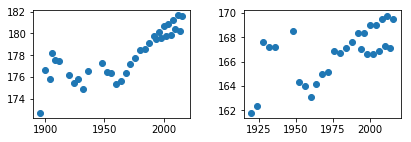

In [11]:
plt.figure(1)
plt.subplot(221)
plt.scatter(x = male_athletes_average_heights_df.YEAR, y = male_athletes_average_heights_df.HEIGHT)

plt.subplot(222)
plt.scatter(x = female_athletes_average_heights_df.YEAR, y = female_athletes_average_heights_df.HEIGHT)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

Indeed, since 1960 (data is more stable), it's observed that height average has increased for both genders.

**2. The average of age is not the same for every sport**

In [12]:
average_age_per_sport_df = athlete_events_df.groupby("SPORT").agg({"AGE":[np.mean,np.std,np.min,np.max]}).reset_index()
average_age_per_sport_df.head(10)

SPORT        AGE                       
                          mean        std  amin  amax
0       Aeronautics  26.000000        NaN  26.0  26.0
1     Alpine Skiing  23.205462   3.987876  14.0  55.0
2          Alpinism  38.812500   9.703736  22.0  57.0
3           Archery  27.935226   8.880789  14.0  71.0
4  Art Competitions  45.901009  12.717193  14.0  97.0
5         Athletics  25.162251   4.397951  12.0  52.0
6         Badminton  25.694986   3.919077  16.0  44.0
7          Baseball  26.240761   4.562377  16.0  44.0
8        Basketball  25.323441   3.879431  16.0  40.0
9     Basque Pelota  26.000000   0.000000  26.0  26.0

In [13]:
average_age_per_sport_df.describe()

AGE                                 
            mean        std       amin       amax
count  66.000000  65.000000  66.000000  66.000000
mean   27.308798   5.406402  16.090909  48.090909
std     5.407361   2.542354   4.201565  11.704999
min    18.737082   0.000000  10.000000  26.000000
25%    24.476738   4.038461  14.000000  41.000000
50%    25.841386   4.422662  15.000000  45.000000
75%    28.999302   6.287242  17.000000  53.000000
max    53.333333  14.364308  37.000000  97.000000

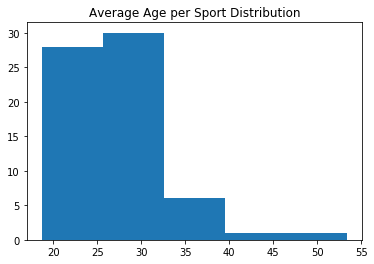

In [14]:
plt.hist(x=average_age_per_sport_df["AGE"]["mean"].values,bins = 5)
plt.title("Average Age per Sport Distribution")
plt.show()

Each average doesn't varies too much from each other, usually the range of ages is between 18 - 32 years. Older athletes are present, but aren't a majority.

In [15]:
athlete_events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270767 entries, 0 to 270766
Data columns (total 17 columns):
ID        270767 non-null int64
NAME      270767 non-null object
SEX       270767 non-null object
AGE       261305 non-null float64
HEIGHT    210684 non-null float64
WEIGHT    207982 non-null float64
TEAM      270767 non-null object
NOC       270767 non-null object
GAMES     270767 non-null object
YEAR      270767 non-null int64
SEASON    270767 non-null object
CITY      270767 non-null object
SPORT     270767 non-null object
EVENT     270767 non-null object
MEDAL     39774 non-null object
REGION    270746 non-null object
NOTES     5039 non-null object
dtypes: float64(3), int64(2), object(12)
memory usage: 47.2+ MB


<h3><font color = '#082E86'> 2.B Data Cleaning </font> <font></h3>

As we observed, the following columns contain missing values:
- Age
- Height
- Weight
- Notes

For each column we applied different approaches in order to fix each missing value.

In [16]:
#We aren't interested on sports that don't have enough records
#At least for 30% of all years, and at least 10% of all teams
minimum = athlete_events_df.YEAR.unique().size * 0.3 * athlete_events_df.TEAM.unique().size*0.1
records_per_sport = athlete_events_df.groupby("SPORT").count().reset_index()[["SPORT","ID"]]
invalid_sports = records_per_sport[records_per_sport["ID"] < minimum].SPORT.values
athlete_events_df = athlete_events_df[~athlete_events_df.SPORT.isin(invalid_sports)]
athlete_events_df.shape

(262270, 17)

In [17]:
minimum

1237.95

In [18]:
#We don't need the Notes column, so lets remove it
athlete_events_df = athlete_events_df.drop(columns=["NOTES"])
athlete_events_df.head()

,ID,NAME,SEX,AGE,HEIGHT,WEIGHT,TEAM,NOC,GAMES,YEAR,SEASON,CITY,SPORT,EVENT,MEDAL,REGION
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China
2,602,Abudoureheman,M,22.0,182.0,75.0,China,CHN,2000 Summer,2000,Summer,Sydney,Boxing,Boxing Men's Middleweight,NaN,China
3,1463,Ai Linuer,M,25.0,160.0,62.0,China,CHN,2004 Summer,2004,Summer,Athina,Wrestling,"Wrestling Men's Lightweight, Greco-Roman",NaN,China
4,1464,Ai Yanhan,F,14.0,168.0,54.0,China,CHN,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Women's 200 metres Freestyle,NaN,China


In [19]:
# If an athlete doesn't have as value for medal, it means he/she didn't won any
# Since age is not dependant to the sport, we may just use the overall mean 
athlete_events_df = athlete_events_df.fillna({"MEDAL": 'No Medal', "AGE": np.round(athlete_events_df["AGE"].mean())})
athlete_events_df.head(5)

,ID,NAME,SEX,AGE,HEIGHT,WEIGHT,TEAM,NOC,GAMES,YEAR,SEASON,CITY,SPORT,EVENT,MEDAL,REGION
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,No Medal,China
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,No Medal,China
2,602,Abudoureheman,M,22.0,182.0,75.0,China,CHN,2000 Summer,2000,Summer,Sydney,Boxing,Boxing Men's Middleweight,No Medal,China
3,1463,Ai Linuer,M,25.0,160.0,62.0,China,CHN,2004 Summer,2004,Summer,Athina,Wrestling,"Wrestling Men's Lightweight, Greco-Roman",No Medal,China
4,1464,Ai Yanhan,F,14.0,168.0,54.0,China,CHN,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Women's 200 metres Freestyle,No Medal,China


In [40]:
# We consider that Height and Weight vary per Sport, Region and Year, so we decided to create an imputer
#that treats this

def clean_columns_by_imputer(df, groupby, missing_columns, stategy = 'mean'):
    missing_columns_x_mean = {}
    global_means = df[missing_columns].mean()
    for mc in missing_columns:
        missing_columns_x_mean[mc] = global_means[mc]
    df = df.groupby(groupby)
    for name, group in df:
        if group[group[missing_columns].isna()].shape == group.shape:
            group = group.fillna(missing_columns_x_mean)
            yield group
        imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
        imputer = imputer.fit(group[missing_columns].values)
        group[missing_columns] = imputer.transform(group[missing_columns].values)
        yield group

athlete_events_df_cp = athlete_events_df.copy().reset_index()
test = athlete_events_df.copy()
#athlete_events_df_cp.groupby(["SPORT"]).describe().head()
for group in clean_columns_by_imputer(athlete_events_df_cp,["SPORT","YEAR","SEX"], ["HEIGHT","WEIGHT"]):
    test.loc[group["index"].values,"HEIGHT"] = group.loc[:,"HEIGHT"].values
    


In [ ]:
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)


In [118]:
athlete_events_df["BMI"] = np.round((athlete_events_df["WEIGHT"])/(athlete_events_df["HEIGHT"]/100)**2)
athlete_events_df["BMI_CLASSIFICATION"] = athlete_events_df["BMI"].map(lambda bmi: "Underweight" if bmi < 18.5 else
                                                                      "Normal" if  18.5 <= bmi <= 24.9 else
                                                                      "Overweight" if 25 <= bmi <= 29.9 else
                                                                      "Obese")